In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

In [11]:
def FD(d):
    #first derivative
    diff = np.zeros_like(d)
    for i in range(1, diff.shape[0]):
        diff[i] = d[i] - d[i-1]
    return diff

def SDW(d, window_size, fd=None):
    result = np.zeros_like(d)
    wb = window_size
    if fd is None:
        diff = FD(d)
    else:
        diff = fd
    for i in range(1, result.shape[0]):
        result[i] = result[i-1] + diff[i]
        if i - wb >= 0:
            result[i] -= diff[i-wb]

    return result

def SDW_ebd(sdw, window_size, threshold):
    min_indexs = np.argsort(sdw)
    eb_mask = np.zeros_like(sdw, dtype=bool)
    for min_i in min_indexs:
        local = sdw[max([0, min_i - window_size]):min_i]
        if len(local) <= 0:
            continue
        local_max_i = np.argmax(local) + max([0, min_i - window_size])
        if sdw[local_max_i] - sdw[min_i] > threshold:
            eb_mask[max([0, local_max_i - window_size]):min_i]=True
    return eb_mask

def MSDW(d, m, M):
    window_size = np.arange(m, M+1)
    window_cnt = len(window_size)
    fd = FD(d)
    sdw = np.zeros((window_cnt, d.shape[0]), np.float64)
    sdw_fd = np.zeros_like(sdw)
    result = np.zeros_like(d)
    w = np.zeros_like(d, int)
    for i, ws in enumerate(window_size):
        sdw[i] = SDW(d, ws, fd=fd)
        sdw_fd[i] = FD(sdw[i])
    
    for t in range(d.shape[0]):
        # a. The numbers of local minimum and maximum within the range, t and t − |W|, should be the same.
        # b. All the first derivatives between times t and t − |W| + 1 should be placed within a range between S'(t − |W|+1) and S'(t), where S'(t) represents the first derivative of the original signal at time t
        # default choose W : m
        # if max-sdw value is multiple, choose smallest W

        window_flag = np.ones(window_cnt, bool)
        #check a
        for i in range(window_cnt):
            local_begin = max([0, t - window_size[i]])
            local_end = t+1
            local_min = np.min(sdw[i, local_begin:local_end])
            local_max = np.max(sdw[i, local_begin:local_end])
            if np.sum(sdw[i, local_begin:local_end] == local_min) != np.sum(sdw[i, local_begin:local_end] == local_max):
                window_flag[i] = False

        #check b
        for i in range(window_cnt):
            if not window_flag[i]:
                continue
            begin = max([0, t - window_size[i] + 1])
            end = t + 1
            s1 = fd[t]
            s2 = fd[begin]
            if s1 > s2:
                tmp = s1
                s1 = s2
                s2 = tmp
            if np.any(sdw_fd[i, begin:end] < s1) or np.any(sdw_fd[i, begin:end] > s2):
                window_flag[i] = False

        #choose W
        w_i = 0
        tmp_sdw_value = -1
        for i in range(window_cnt):
            if not window_flag[i]:
                continue
            if tmp_sdw_value < sdw[i, t]:
                w_i = i
                tmp_sdw_value = sdw[i, t]

        #store
        w[t] = w_i + m
        result[t] = sdw[w_i, t]
    return w, result
        

def MSDW_ebd(msdw, w, max_window_width, threshold, min_th_abs_ratio=0.4):
    row_n = msdw.shape[0]
    range_counter = 0
    eb_range = np.zeros((row_n, 2),int)
    
    index_localmin = np.zeros(((row_n+1)//2), int)
    index_localmax = np.zeros(((row_n+1)//2), int)
    localmin_n = 0
    localmax_n = 0
    lr_value_spike = np.zeros(((row_n+1)//2, 2))
    lr_width_spike = np.zeros(((row_n+1)//2, 2))
    bool_accpet = np.zeros(((row_n+1)//2))

    bool_tmp_up = 0
    bool_tmp_down = 0
    bool_min_found = 0
    tmp_max_id = 0
    tmp_min_id = 0

    is_criteria_satisfied = (lambda sum_val, threshold, min_th_abs_ratio, window_acc_v_max, window_acc_v_min :
                            (sum_val > threshold and window_acc_v_max > threshold * min_th_abs_ratio and window_acc_v_min < -threshold*min_th_abs_ratio))

    for i in range(2, row_n):
        if msdw[i-1] > msdw[i-2] and msdw[i-1] == msdw[i]:
            tmp_max_id = i-1
            bool_tmp_up = 1
            bool_tmp_down = 0
        elif msdw[i-1] < msdw[i-2] and msdw[i-1] == msdw[i]:
            tmp_min_id = i-1
            bool_tmp_down = 1
            bool_tmp_up = 1
        elif msdw[i-1] == msdw[i-2]:
            if msdw[i-1] > msdw[i]:
                if bool_tmp_up:
                    index_localmax[localmax_n] = int(round((i-1+tmp_max_id)/2))
                    localmax_n += 1
                bool_tmp_up = 0
                bool_tmp_down = 0
            elif msdw[i-1] < msdw[i]:
                if bool_tmp_down:
                    index_localmin[localmin_n] = int(round((i-1+tmp_min_id)/2))
                    localmin_n += 1
                    bool_min_found = 1
                bool_tmp_up = 0
                bool_tmp_down = 0             
        elif msdw[i-1] > msdw[i-2] and msdw[i-1] > msdw[i]:
            index_localmax[localmax_n] = i-1
            localmax_n += 1
        elif msdw[i-1] < msdw[i-2] and msdw[i-1] < msdw[i]:
            index_localmin[localmin_n] = i-1
            localmin_n += 1
            bool_min_found = 1

        if bool_min_found and localmax_n > 0:
            min_id = index_localmin[localmin_n-1]
            sum_val = msdw[index_localmax[localmax_n-1]] - msdw[min_id]
            tmp_max_sum = sum_val
            cur_max_pos = index_localmax[localmax_n-1]
            r_start = -1

            lr_value_spike[localmin_n-1, :] = [msdw[index_localmax[localmax_n-1]], msdw[min_id]]
            lr_width_spike[localmin_n-1, :] = [w[cur_max_pos], -min_id]
            
            bool_accpet[localmin_n-1] = is_criteria_satisfied(sum_val, threshold, min_th_abs_ratio, msdw[cur_max_pos], msdw[min_id])
            if(bool_accpet[localmin_n-1]):
                r_start = cur_max_pos - w[cur_max_pos]
                if range_counter > 0 and r_start <= eb_range[range_counter-1, 1]:
                    r_start = eb_range[range_counter-1, 1]
            
            for k in range(localmax_n):
                if localmax_n-1-k<=0 or index_localmin[localmin_n-1] - index_localmax[localmax_n-1-1-k] > max_window_width:
                    break

                cur_max_pos = index_localmax[localmax_n-1-1-k]
                prev_max_pos = index_localmax[localmax_n-1-k]
                sum_val = sum_val + msdw[cur_max_pos] - msdw[prev_max_pos]

                r_start_tmp = cur_max_pos - w[cur_max_pos]

                tmp_check_result = is_criteria_satisfied(sum_val, threshold, min_th_abs_ratio, msdw[cur_max_pos], msdw[min_id])
                if(sum_val > tmp_max_sum and (range_counter == 0 or r_start_tmp > eb_range[range_counter-1,0] or r_start_tmp <= eb_range[range_counter-1,0]) and tmp_check_result):
                    tmp_max_sum = sum_val
                    if range_counter == 0 or r_start_tmp >= eb_range[range_counter-1, 1]:
                        r_start = r_start_tmp
                    while range_counter > 0 and r_start_tmp <= eb_range[range_counter-1, 0]:
                        range_counter = range_counter -1
                        if range_counter > 0 and r_start_tmp < eb_range[range_counter-1, 1]:
                            r_start = eb_range[range_counter-1, 1]
                        else:
                            r_start = r_start_tmp
                    bool_accpet[localmin_n-1] = tmp_check_result
                    lr_value_spike[localmin_n-1, :] = [msdw[index_localmax[localmax_n-1-1-k]], msdw[min_id]]
                    lr_width_spike[localmin_n-1, :] = [w[cur_max_pos], -min_id]

            if r_start > 0:
                range_counter = range_counter + 1
                eb_range[range_counter-1, :] = [r_start, min_id]
            bool_min_found = 0

    eb_mask = np.zeros(row_n, bool)
    for i in range(range_counter):
        eb_mask[eb_range[i,0]:eb_range[i,1]+1] = True
    return eb_mask

def mask2range(mask):
    result = []
    begin = 0
    flag = 0
    for i, value in enumerate(mask):
        if (not flag) and value:
            flag = 1
            begin = i
        elif flag and (not value):
            flag = 0
            result += [[begin, i]]
    if flag:
        result += [[begin, len(mask)]]
    return np.array(result, int)

def eb_interpolation(d, begin, end):
    s_b = d[end-1]
    s_a = d[begin]
    #calculate interpolation_value
    d[begin:end] = np.arange(0, end-begin, dtype=d.dtype) * ((s_b-s_a)/(end-begin-1)) + s_a
    return

In [41]:
def get_data(dir, subject, trial, pattern):
    data = pd.read_csv(f"{dir}/{subject:02}/_S{subject:02}_T{trial:02}_{pattern:02}.csv")
    return np.array(data)

def get_data_all(dir, subject_list=np.arange(1,19), trial_list=np.arange(1,4), pattern_list=np.arange(1,11)):
    #output structure : (subjects, trials, patterns) PYTHON LIST
    #          - list elements : (time series, channels(x, y)) numpy array

    #output init
    data = [0] * len(subject_list)
    for i in range(len(subject_list)):
        data[i] = [0] * len(trial_list)
        for j in range(len(trial_list)):
            data[i][j] = [0] * len(pattern_list)
    
    #read data - loop
    for i, subject in enumerate(subject_list):
        for j, trial in enumerate(trial_list):
            for k, pattern in enumerate(pattern_list):
                data[i][j][k] = get_data(dir, subject, trial, pattern)
    
    return data

def get_row_data(dir):
    data = None
    with open(dir, "r") as f:
        #file line count
        for count, line in enumerate(f):
            #empty line 만날 경우, count 1 감소시킨 후 탈출
            if line == "" or line == "\n":
                count -= 1
                break
        #원래는 count + 1 == 파일_문장_수 이지만, 첫번째 줄은 무시해야 하므로 그냥 count로 계산함.
        line_cnt = count

        #file pointer reset
        f.seek(0)
        #reading
        data = np.zeros((line_cnt, 8), np.float64)
        for i, line in enumerate(f):
            #ignore (first line & out of index)
            if i==0 or i>line_cnt:
                continue
            split_line = list(map(float, line.split()[1:]))
            data[i-1, :len(split_line)] = split_line
    return data
            
def get_row_event(dir):
    data = None
    with open(dir, "r") as f:
        #file line count
        for count, line in enumerate(f):
            #empty line 만날 경우, count 1 감소시킨 후 탈출
            if line == "" or line == "\n":
                count -= 1
                break
        #원래는 count + 1 == 파일_문장_수 이지만, 첫번째 줄은 무시해야 하므로 그냥 count로 계산함.
        line_cnt = count

        #file pointer reset
        f.seek(0)
        #reading
        data = np.zeros((line_cnt), np.int32)
        for i, line in enumerate(f):
            #ignore (first line & out of index)
            if i==0 or i>line_cnt:
                continue
            strdata = line.split()
            data[i-1] = int(strdata[4].split(".")[0])
    return data

def row_data_processing(dir, subject_num, trial_num, return_only_result=True):
    sd_name = f"{dir}/s{subject_num:02}_{trial_num:02}.txt"
    ed_name = f"{dir}/e{subject_num:02}_{trial_num:02}.txt"


    print(f"try read row data file : {sd_name}", end="\t")
    sd = get_row_data(sd_name)
    print(sd.shape)

    print(f"try read event data file : {ed_name}", end="\t")
    ed = get_row_event(ed_name)
    print(ed.shape)
    
    print(f"try down sampling to 64 hz", end="\t")
    time_len = sd.shape[0]/2048
    target_len = int(time_len * 64)
    down_sd = np.zeros((target_len, sd.shape[1]),np.float64)
    for ch in range(sd.shape[1]):
        down_sd[:,ch] = signal.resample(sd[:,ch], target_len)
    print(down_sd.shape)

    med_filter_kernel_size = 7
    print(f"try apply median filter... kernel_size = {med_filter_kernel_size}", end="\t")
    med_filtered = np.zeros_like(down_sd)
    for ch in range(med_filtered.shape[0]):
        med_filtered[ch,:] = np.median(down_sd[max([0, ch - (med_filter_kernel_size//2)]):ch+(med_filter_kernel_size//2), :], axis=0)
    print(f"Done.")

    print(f"try Eye Blink Detection in 0 ch...", end="\t")
    min_w = 6
    max_w = 15
    th = 150
    min_th_ratio = 0.4
    w, msdw = MSDW(med_filtered[:,0], min_w, max_w)
    eb_mask = MSDW_ebd(msdw, w, max_w, th, min_th_ratio)
    eb_range = mask2range(eb_mask)
    print(f"Done.")

    print(f"try Eye Blink Removal...", end="\t")
    eb_removed = med_filtered.copy()
    for ch in range(eb_removed.shape[1]):
        for begin, end in eb_range:
            eb_interpolation(eb_removed[:,ch], begin, end)
    print(f"Done.")

    print(f"try baseline removal...", end="\t")
    ignore_first_event = 0
    if ed.shape[0] % 2:
        ignore_first_event = 1
        print(f"\n\t: first event was ignored...", end="\t")
    bl_removed = [None] * 10
    for i in range(10):
        begin = ed[i*2+ignore_first_event]
        end = ed[i*2+ignore_first_event+1]
        begin = int(begin/2048 * 64)
        end = int(end / 2048 * 64) + 1
        bl_removed[i] = eb_removed[begin:end, :]
    print(f"Done.")

    print(f"try Extraction of Horiziontal and Vertical Conponents...", end="\t")
    extracted = [None] * 10
    for i in range(10):
        extracted[i] = np.zeros((bl_removed[i].shape[0], 2), dtype=bl_removed[i].dtype)
        extracted[i][:,0] = bl_removed[i][:,2] - bl_removed[i][:,0]
        extracted[i][:,1] = bl_removed[i][:,3] - bl_removed[i][:,4]
    print(f"Done.")

    return {
        "row_data":sd,
        "event_data":ed,
        "down_sampled_data":down_sd,
        "median_filtered_data":med_filtered,
        "MSDW_data":msdw,
        "MSDW_W":w,
        "eye_blink_mask":eb_mask,
        "eye_blink_range":eb_range,
        "eye_blink_removed":eb_removed,
        "baseline_removed":bl_removed,
        "extracted":extracted,
    }

def row_data_simple_processing(dir, sub_n, trial_n):
    sd_name = f"{dir}/s{sub_n:02}_{trial_n:02}.txt"
    ed_name = f"{dir}/e{sub_n:02}_{trial_n:02}.txt"


    print(f"try read row data file : {sd_name}", end="\t")
    sd = get_row_data(sd_name)
    print(sd.shape)

    print(f"try read event data file : {ed_name}", end="\t")
    ed = get_row_event(ed_name)
    print(ed.shape)
    
    print(f"try down sampling to 64 hz", end="\t")
    time_len = sd.shape[0]/2048
    target_len = int(time_len * 64)
    down_sd = np.zeros((target_len, sd.shape[1]),np.float64)
    for ch in range(sd.shape[1]):
        down_sd[:,ch] = signal.resample(sd[:,ch], target_len)
    print(down_sd.shape)

    med_filter_kernel_size = 7
    print(f"try apply median filter... kernel_size = {med_filter_kernel_size}", end="\t")
    med_filtered = np.zeros_like(down_sd)
    for ch in range(med_filtered.shape[0]):
        med_filtered[ch,:] = np.median(down_sd[max([0, ch - (med_filter_kernel_size//2)]):ch+(med_filter_kernel_size//2), :], axis=0)
    print(f"Done.")

    print(f"try baseline removal...", end="\t")
    ignore_first_event = 0
    if ed.shape[0] % 2:
        ignore_first_event = 1
        print(f"\n\t: first event was ignored...", end="\t")
    bl_removed = [None] * 10
    for i in range(10):
        begin = ed[i*2+ignore_first_event]
        end = ed[i*2+ignore_first_event+1]
        begin = int(begin/2048 * 64)
        end = int(end / 2048 * 64) + 1
        bl_removed[i] = med_filtered[begin:end, :]
    print(f"Done.")

    print(f"try Extraction of Horiziontal and Vertical Conponents...", end="\t")
    extracted = [None] * 10
    for i in range(10):
        extracted[i] = np.zeros((bl_removed[i].shape[0], 2), dtype=bl_removed[i].dtype)
        extracted[i][:,0] = bl_removed[i][:,2] - bl_removed[i][:,0]
        extracted[i][:,1] = bl_removed[i][:,3] - bl_removed[i][:,4]
    print(f"Done.")

    return extracted

def fft_analysis(d, fs):
    #d에 대해 FFT 변환을 수행하고, 
    channel = d.shape[1]
    freqs = np.linspace(-fs / 2, fs / 2, len(d))
    fft_val = np.array([np.fft.fft(d[:,i]) / len(d) for i in range(0, channel)])
    fft_magnitude = abs(fft_val)
    amp = np.array([np.fft.fftshift(fft_magnitude[i]) for i in range(0, channel)])

    #주파수 값을 y(amp)값 기준으로 인덱스 번호를 desc 정렬
    argsorted = np.array([np.argsort(amp[i])[::-1] for i in range(0, channel)])

    return freqs, amp, argsorted

def fft_plot(d, fs, channel_list=None, xlim=(-32,32), ylim=(0,2.5)):
    if channel_list is None:
        channel_list = np.arange(0, d.shape[1])
    ch_n = len(channel_list)

    freq, amp, _ = fft_analysis(d, fs)
    amp_t = np.transpose(amp, [1,0])
    
    fig_x = min([4, ch_n])
    fig_y = int(math.ceil(ch_n/4))
    plt.figure(figsize=(4 * fig_x, 2 * fig_y))
    for i in range(ch_n):
        plt.subplot(fig_y, fig_x, i+1)
        plt.title(f"ch {channel_list[i]}")
        plt.xlim(xlim)
        plt.ylim(ylim)
        plt.stem(freq, amp_t[:,channel_list[i]])
    plt.tight_layout()
    plt.show()
    return

In [13]:
# data = get_data_all("./csv_eb_removed/")

In [14]:
# data[0][0][0].shape

In [15]:
# plt.plot(data[0][0][0][:,0], data[0][0][0][:,1])

In [16]:
# plt.plot(data[0][0][0][:,1])

In [17]:
data = row_data_processing("/home/user/workspace/research/eye-writing/row_data/", 1, 1)

try read row data file : /home/user/workspace/research/eye-writing/row_data//s01_01.txt	(464896, 8)
try read event data file : /home/user/workspace/research/eye-writing/row_data//e01_01.txt	(20,)
try down sampling to 64 hz	(14528, 8)
try apply median filter... kernel_size = 7	Done.
try Eye Blink Detection in 0 ch...	Done.
try Eye Blink Removal...	Done.
try baseline removal...	Done.
try Extraction of Horiziontal and Vertical Conponents...	Done.


In [18]:
# fft_plot(data["row_data"], 2048)

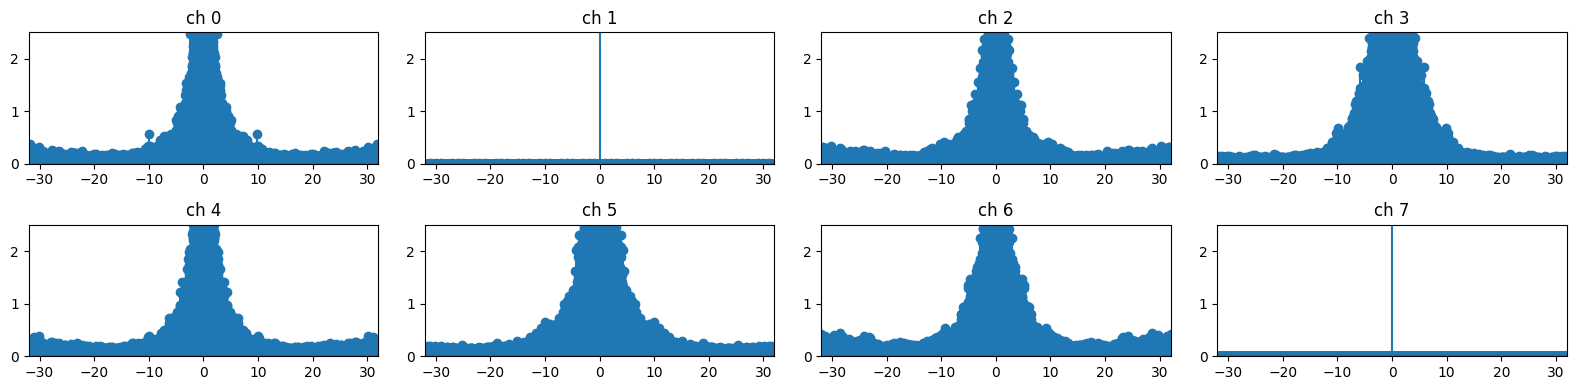

In [19]:
fft_plot(data["down_sampled_data"], 64)

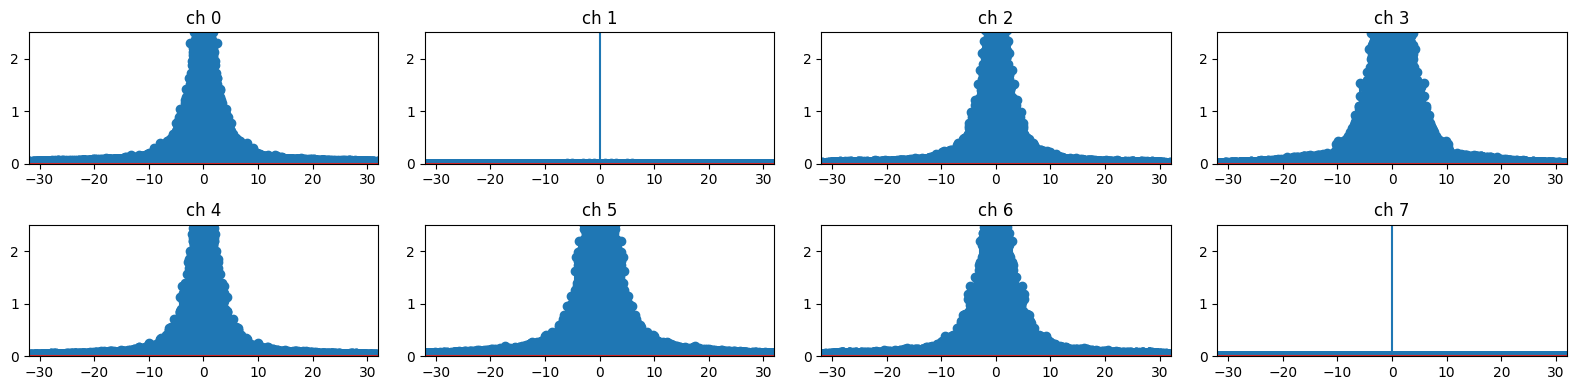

In [20]:
fft_plot(data["median_filtered_data"], 64)

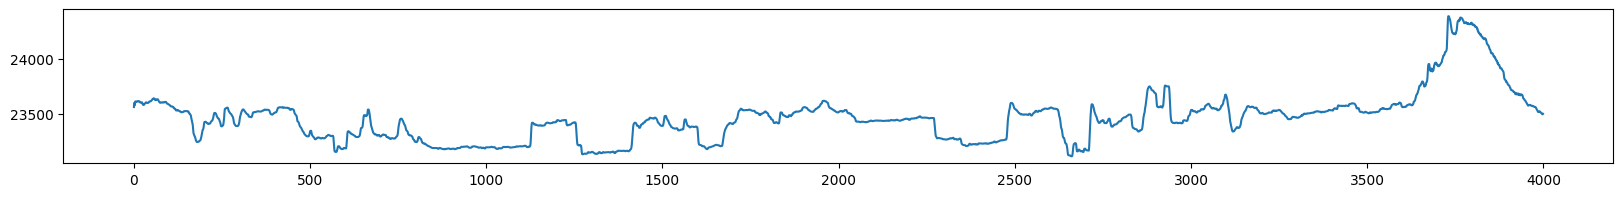

In [21]:
plt.figure(figsize=(20,2))
plt.plot(data["median_filtered_data"][0:4000,0])
plt.show()

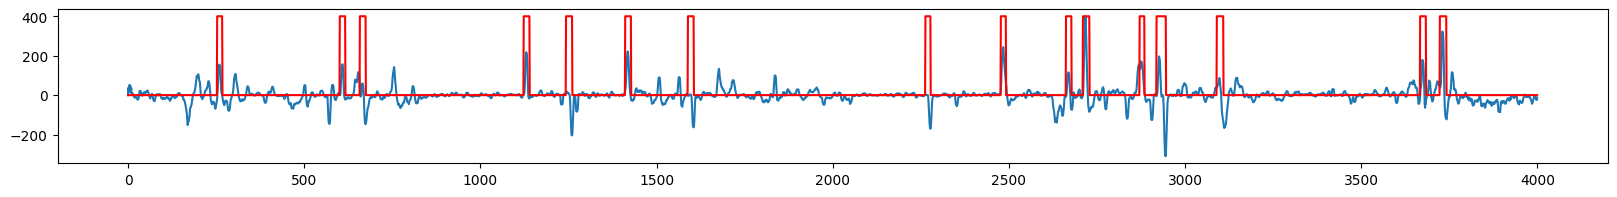

In [35]:
sdw = SDW(data["median_filtered_data"][:4000,0], 7)
eb_mask = SDW_ebd(sdw, 7, 150)
plt.figure(figsize=(20,2))
gca = plt.gca()
gca.plot(sdw)
gca.plot(eb_mask * 400, color="red")
plt.show()

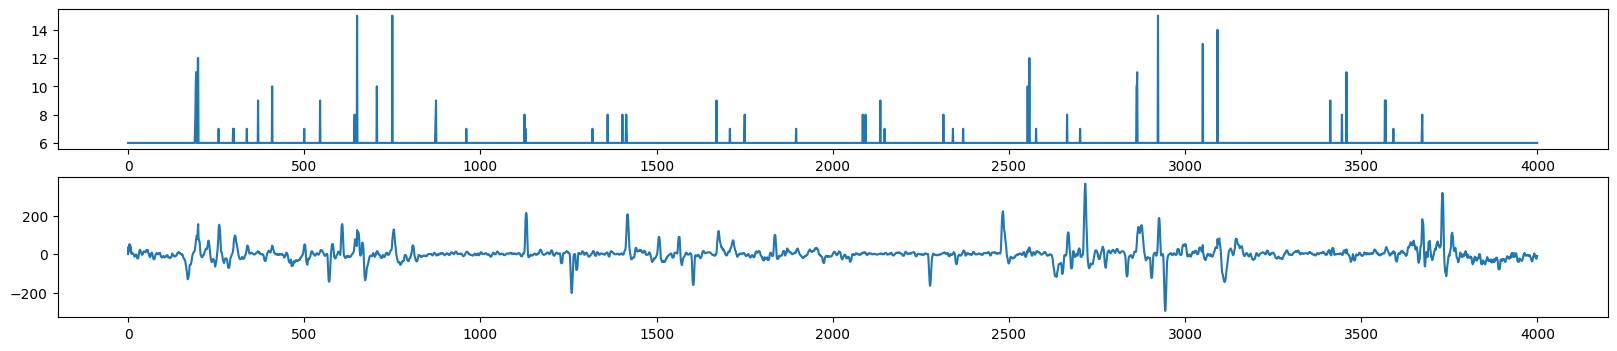

In [36]:
w, msdw = MSDW(data["median_filtered_data"][0:4000,0], 6, 15)
plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
gca = plt.gca()
gca.plot(w)
plt.subplot(2,1,2)
gca = plt.gca()
gca.plot(msdw)
plt.show()

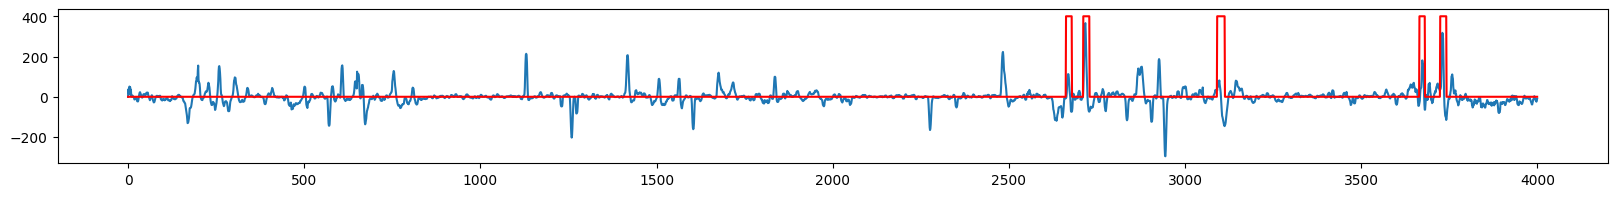

In [37]:
w, msdw = MSDW(data["median_filtered_data"][:4000,0], 6, 15)
eb_mask = MSDW_ebd(msdw, w, 15, 150, 0.4)
plt.figure(figsize=(20,2))
gca = plt.gca()
gca.plot(msdw)
gca.plot(eb_mask * 400, color="red")
plt.show()

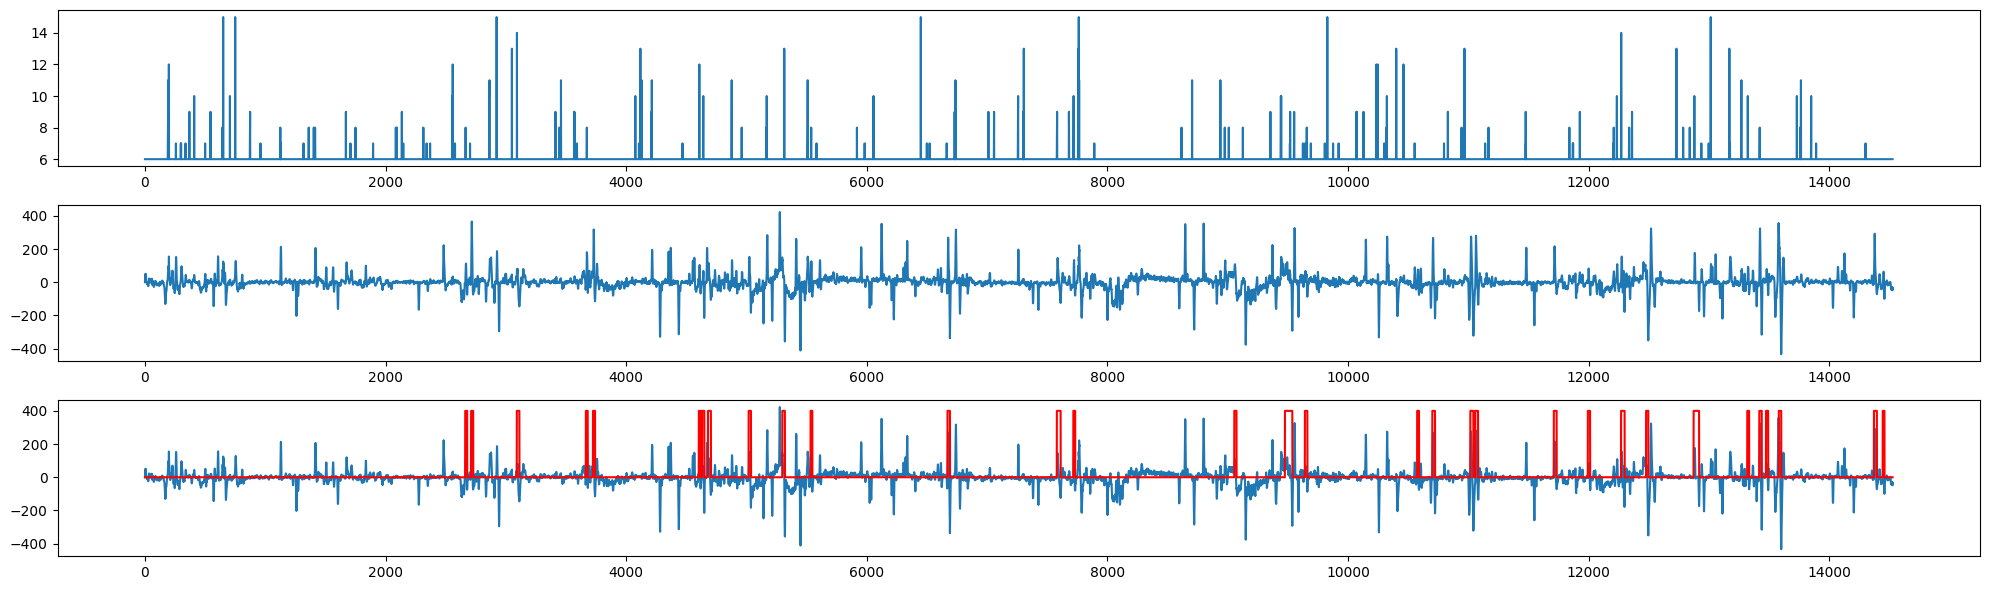

In [38]:
plt.figure(figsize=(20,6))
plt.subplot(3,1,1)
gca = plt.gca()
gca.plot(data["MSDW_W"])
plt.subplot(3,1,2)
gca = plt.gca()
gca.plot(data["MSDW_data"])
plt.subplot(3,1,3)
gca = plt.gca()
gca.plot(data["MSDW_data"])
gca.plot(data["eye_blink_mask"] * 400, color="red")
plt.tight_layout()
plt.show()

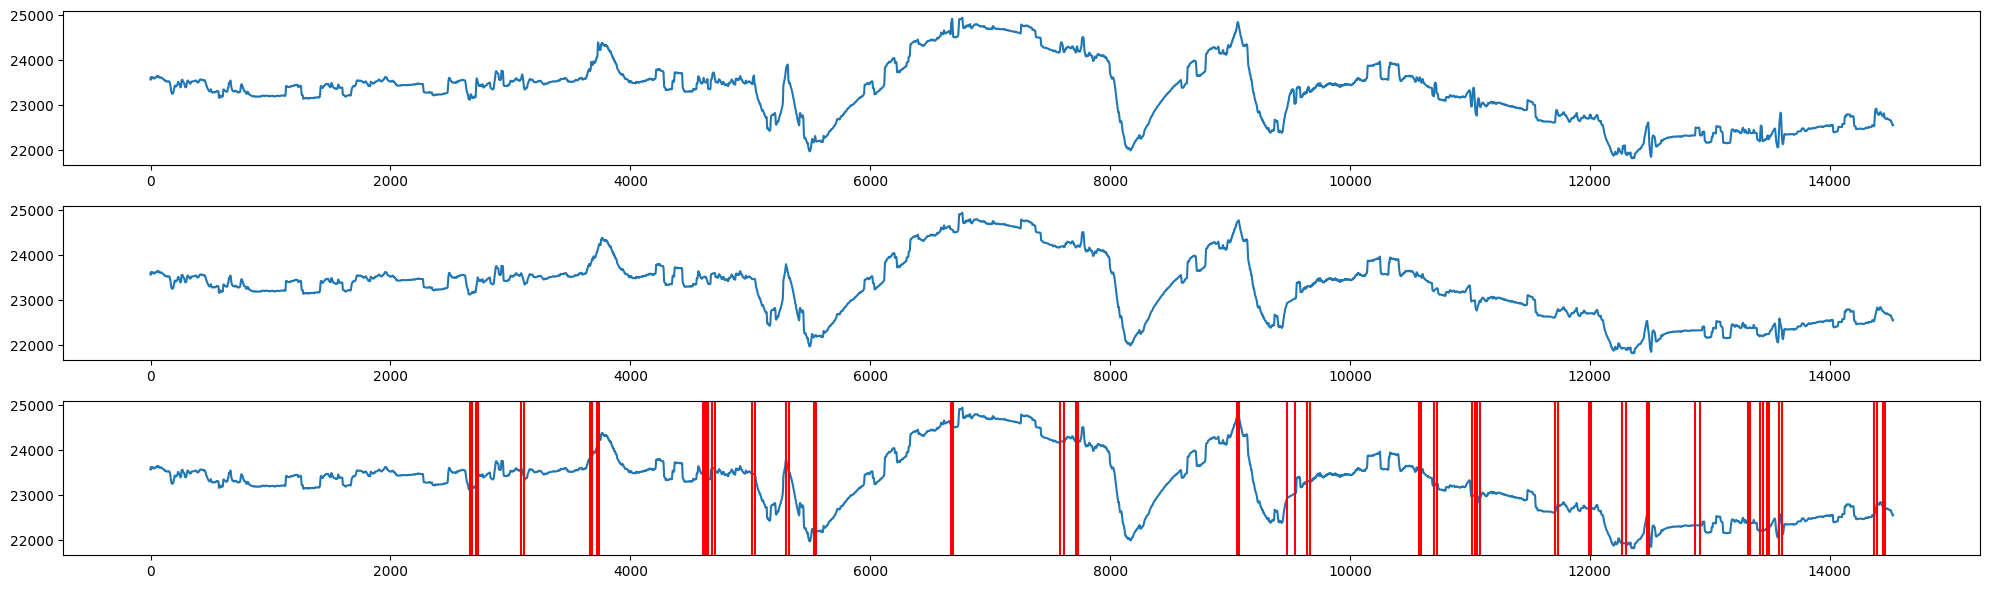

In [39]:
plt.figure(figsize=(20,6))
plt.subplot(3,1,1)
gca = plt.gca()
gca.plot(data["median_filtered_data"][:,0])
plt.subplot(3,1,2)
gca = plt.gca()
gca.plot(data["eye_blink_removed"][:,0])
plt.subplot(3,1,3)
gca = plt.gca()
gca.plot(data["eye_blink_removed"][:,0])
for begin, end in data["eye_blink_range"]:
    gca.axvline(x=begin, color="red")
    gca.axvline(x=end, color="red")
plt.tight_layout()
plt.show()

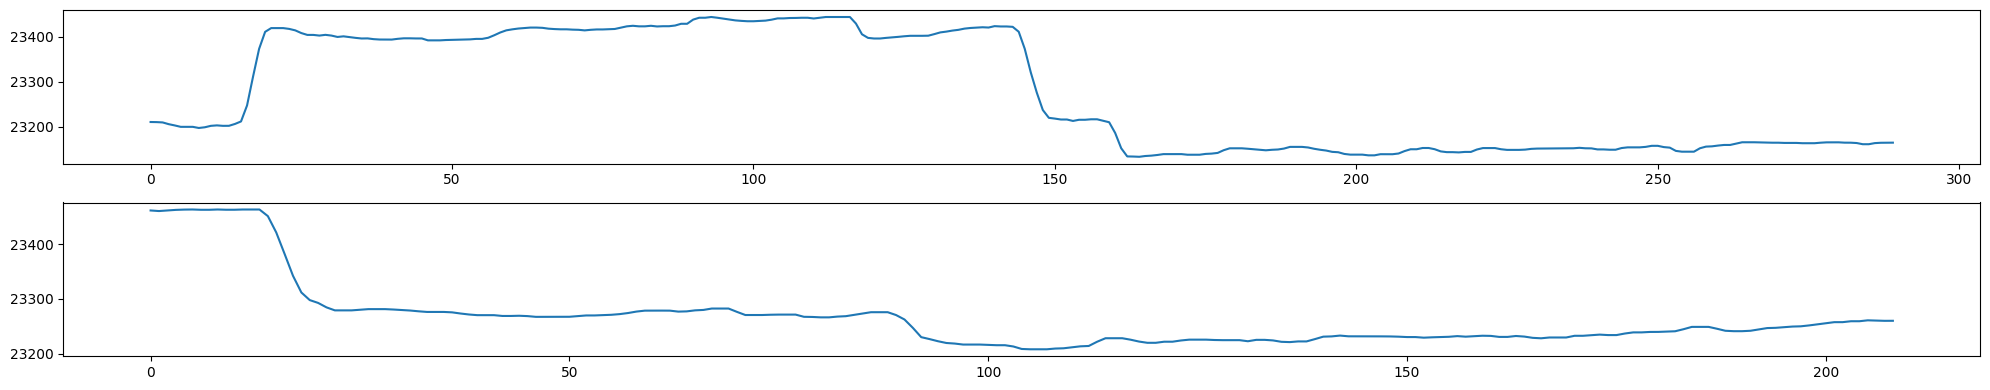

In [40]:
plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
gca = plt.gca()
gca.plot(data["baseline_removed"][0][:,0])
plt.subplot(2,1,2)
gca = plt.gca()
gca.plot(data["baseline_removed"][1][:,0])
plt.tight_layout()
plt.show()

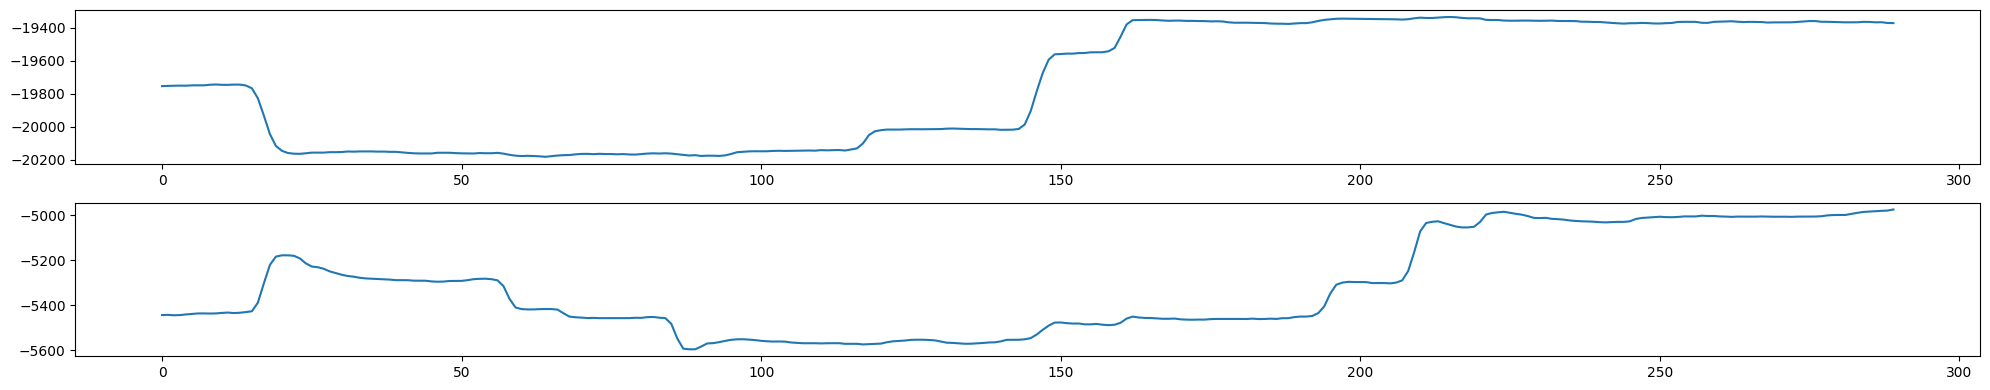

In [28]:
plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
gca = plt.gca()
gca.plot(data["extracted"][0][:,0])
plt.subplot(2,1,2)
gca = plt.gca()
gca.plot(data["extracted"][0][:,1])
plt.tight_layout()
plt.show()

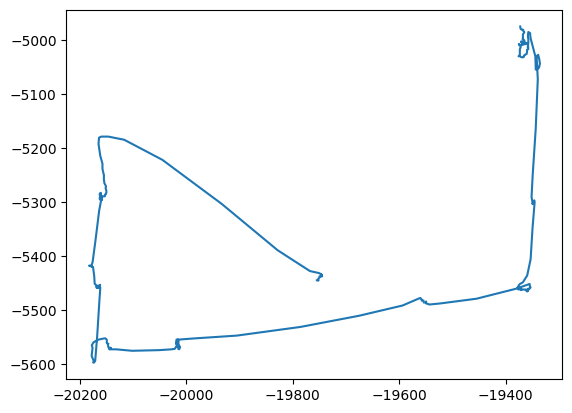

In [29]:
plt.plot(data["extracted"][0][:,0], data["extracted"][0][:,1])

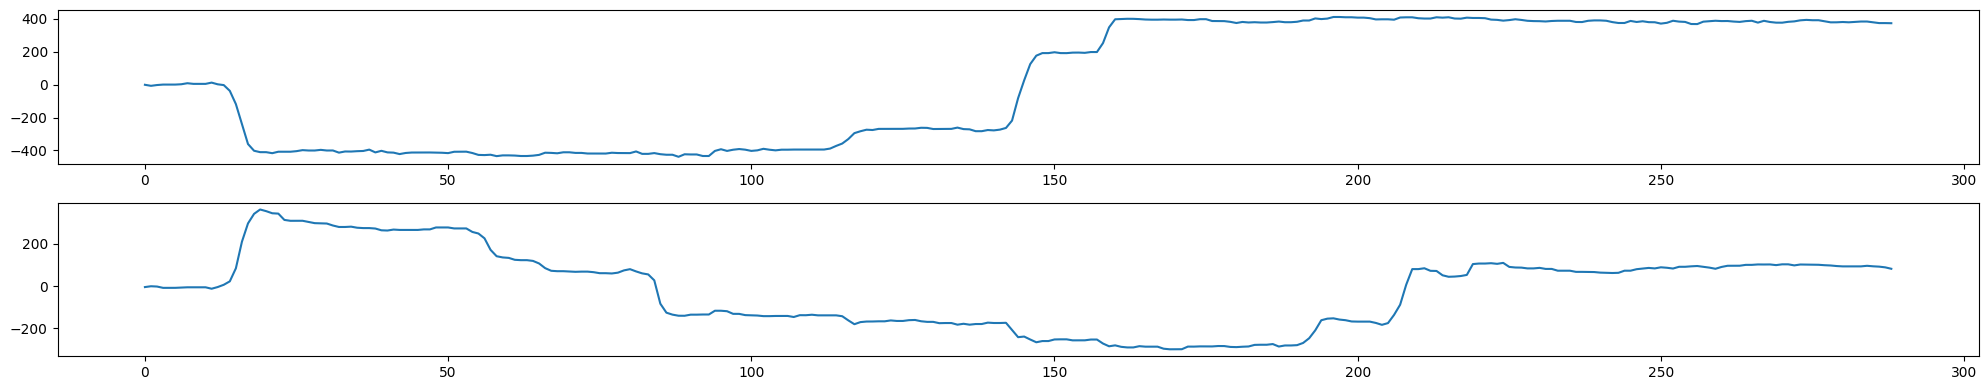

In [30]:
test_data = get_data("/home/user/workspace/research/eye-writing/csv_eb_removed/", 1, 1, 1)
plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
gca = plt.gca()
gca.plot(test_data[:,0])
plt.subplot(2,1,2)
gca = plt.gca()
gca.plot(test_data[:,1])
plt.tight_layout()
plt.show()

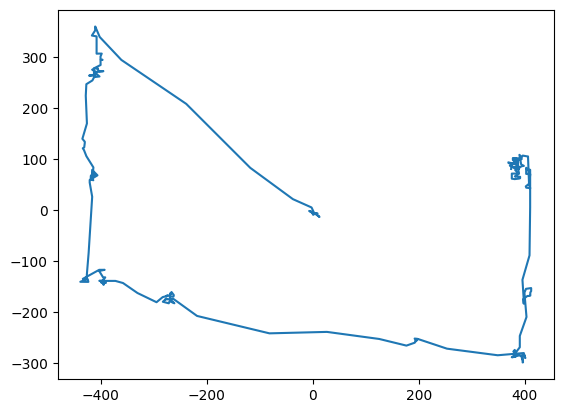

In [31]:
plt.plot(test_data[:,0], test_data[:,1])

try read row data file : /home/user/workspace/research/eye-writing/row_data//s01_01.txt	(464896, 8)
try read event data file : /home/user/workspace/research/eye-writing/row_data//e01_01.txt	(20,)
try down sampling to 64 hz	(14528, 8)
try apply median filter... kernel_size = 7	Done.
try baseline removal...	Done.
try Extraction of Horiziontal and Vertical Conponents...	Done.


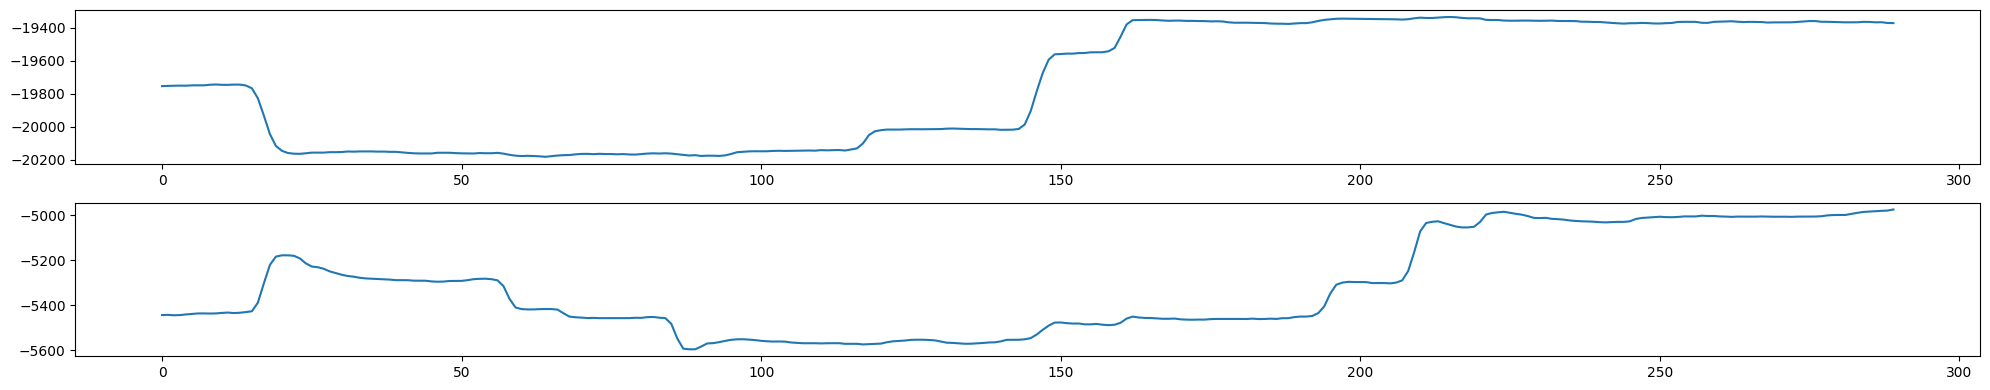

In [43]:
tmpdata = row_data_simple_processing("/home/user/workspace/research/eye-writing/row_data/", 1, 1)
plt.figure(figsize=(20,4))
plt.subplot(2,1,1)
gca = plt.gca()
gca.plot(tmpdata[0][:,0])
plt.subplot(2,1,2)
gca = plt.gca()
gca.plot(tmpdata[0][:,1])
plt.tight_layout()
plt.show()

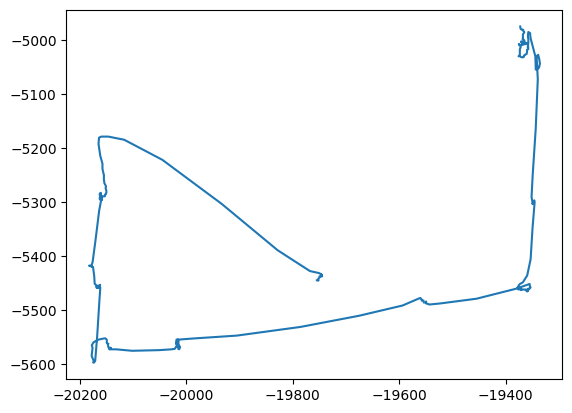

In [45]:
plt.plot(tmpdata[0][:,0], tmpdata[0][:,1])

In [32]:
7/3

2.3333333333333335

In [33]:
math.sqrt(np.float32(7/3))

1.5275252056383468

In [34]:
math.sqrt(7/3)

1.5275252316519468

In [49]:
source = f"/home/user/workspace/research/eye-writing/row_data/"
target = f"/home/user/workspace/research/eye-writing/self_data"
import os
if not os.path.isdir(f"{target}"):
    os.mkdir(f"{target}")

for pattern_n in range(0, 10):
    if not os.path.isdir(f"{target}/{pattern_n}"):
        os.mkdir(f"{target}/{pattern_n}")

for sub_n in range(1, 19):
    for tri_n in range(1, 4):
        d = row_data_simple_processing(source, sub_n, tri_n)
        for pattern_n in range(0, 10):
            np.save( f"{target}/{pattern_n}/{(sub_n-1)*3+tri_n}.npy",d[pattern_n])

try read row data file : /home/user/workspace/research/eye-writing/row_data//s01_01.txt	(464896, 8)
try read event data file : /home/user/workspace/research/eye-writing/row_data//e01_01.txt	(20,)
try down sampling to 64 hz	(14528, 8)
try apply median filter... kernel_size = 7	Done.
try baseline removal...	Done.
try Extraction of Horiziontal and Vertical Conponents...	Done.
try read row data file : /home/user/workspace/research/eye-writing/row_data//s01_02.txt	(497664, 8)
try read event data file : /home/user/workspace/research/eye-writing/row_data//e01_02.txt	(20,)
try down sampling to 64 hz	(15552, 8)
try apply median filter... kernel_size = 7	Done.
try baseline removal...	Done.
try Extraction of Horiziontal and Vertical Conponents...	Done.
try read row data file : /home/user/workspace/research/eye-writing/row_data//s01_03.txt	(401408, 8)
try read event data file : /home/user/workspace/research/eye-writing/row_data//e01_03.txt	(20,)
try down sampling to 64 hz	(12544, 8)
try apply medi